# Assignment 8: Transformers

---

## Text-to-Text for Summarization

Transformers are powerful attention-based models that have great power for generalization.
Googles T5 is a popular and recent Text-to-Text transformer.
A cool blog post about it can be found on Googles [AI.blog](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html).
T5 is supposedly able to handle all kinds of NLP tasks like summarization, question answering, and text classification.
The [paper](https://arxiv.org/abs/1910.10683) sheds some light on what they actually wanted to achieve.
In our exercise we want to answer the question if we can use a pre-trained transformer model to summarize abstracts of our theses so they come close to their original titles?
We will try this task in two ways: *out of the box* and *fine-tuning* on our dataset.
Both should summarize the abstract to a thesis title.

## Data

Download and use the theses.csv dataset from the Supplemental Materials in the Files section of our Microsoft Teams group. 
This dataset contains approximately 3,000 thesis topics chosen by students in the past. Each entry includes a thesis title along with the corresponding abstract in the Abstract column. 
Note that not all entries include abstracts, so some filtering steps will be necessary.

## Basic Setup

First, you will need to download a German T5 model from this [link](https://huggingface.co/ml6team/mt5-small-german-finetune-mlsum)
You can either clone the model repository or, preferably, download it directly using the [Transformers](https://huggingface.co/docs/transformers/index) library (recommended!).
To get started, install the required libraries (you will need the sentencepiece tokenizer for this specific transformer model).
Then, use the following code to load the tokenizer and model:
```python
# pip install transformers sentencepiece

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("ml6team/mt5-small-german-finetune-mlsum")
model = AutoModelForSeq2SeqLM.from_pretrained("ml6team/mt5-small-german-finetune-mlsum")
```

*In this Jupyter Notebook, we will provide the steps to solve this task and give hints via functions & comments. However, code modifications (e.g., function naming, arguments) and implementation of additional helper functions & classes are allowed. The code aims to help you get started.*

---

### Prepare the Data

1.1 As always... spend some time on preparing the dataset. It may be helpful to lower-case the data and to filter for German titles.

1.2 Remove very short titles, you can evaluate by a metric, e.g. len(abstract_words) / len(thesis title words). Furthermore, check the suitability of the model (e.g., max source / target lengths).

1.3 Tokenize properly and implement helper classes / functions which handles your tokenized data with respect to your model and task!

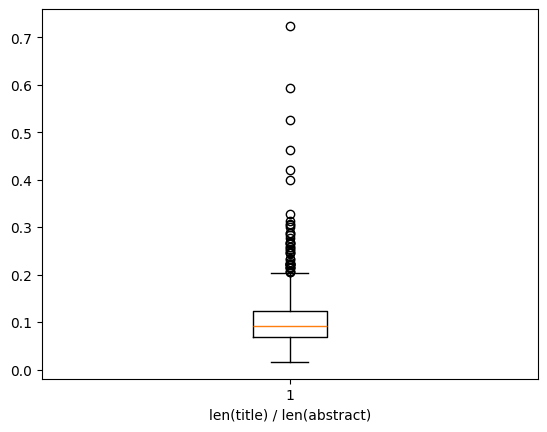

lower quartile: 0.06767247816559398


In [1]:
### YOUR CODE HERE

from typing import TypedDict
import torch
from torch import Tensor
from functools import reduce
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
from pandas import DataFrame
import numpy as np
from numpy import ndarray
from matplotlib import pyplot as plt
import csv

DATA_PATH = "../6-nnet_attn/data/theses2022.csv"
LENGTH_RATIO_THRESHOLD = 0.1

@dataclass
class Thesis:
    registration_date: str
    due_date: str
    year_academic: int
    type: str
    degree: str
    language: str
    title: str
    abstract: str

class _Thesis(TypedDict):
    Anmeldedatum: str
    Abgabedatum: str
    JahrAkademisch: str
    Art: str
    Grad: str
    Sprache: str
    Titel: str
    Abstract: str

def to_thesis(thesis: _Thesis) -> Thesis:
    return Thesis(
        registration_date=thesis["Anmeldedatum"],
        due_date=thesis["Abgabedatum"],
        year_academic=int(thesis["JahrAkademisch"]),
        type=thesis["JahrAkademisch"],
        degree=thesis["Grad"],
        language=thesis["Sprache"],
        title=thesis["Titel"],
        abstract=thesis["Abstract"]
    )

def load_theses_dataset(filepath) -> DataFrame:
    """Loads all theses instances and returns them as a dataframe."""
    ### YOUR CODE HERE
    
    lists = {key: [] for key in Thesis.__dataclass_fields__.keys()}
    with open(filepath, encoding="utf-8-sig") as fp:
        theses = map(to_thesis, csv.DictReader(fp.readlines(), delimiter=";")) # type: ignore
        for thesis in theses:
            if thesis.language == "DE" and thesis.abstract.strip() != "" and thesis.title != "" and len(thesis.title) < len(thesis.abstract):
                for key in lists:
                    lists[key].append(thesis.__dict__[key])
    return DataFrame(lists)

dataframe = load_theses_dataset(DATA_PATH)

length_ratios = np.empty(dataframe.shape[0])
for i, (_, row) in enumerate(dataframe.iterrows()):
    length_ratios[i] = (len(row["title"])) / (len(row["abstract"]))

plt.boxplot(length_ratios)
plt.xlabel("len(title) / len(abstract)")
plt.show()

lower_quartile = np.percentile(length_ratios, 25)
print(f"lower quartile: {lower_quartile}")

### END YOUR CODE

### Task 1: Out of the box

Let's see if we can put this to use in our thesis example from the previous exercises.
Follow the [instructions](https://huggingface.co/ozcangundes/mt5-small-turkish-summarization) for a Turkish summarization model
on [Hugging Face](https://huggingface.co/). 
The steps should work the same for our German task.
Implement some summarization and check qualitatively if you're content with the results.
When generating, check some of the model parameters like **beamsize**, **repetition_penalty**, **length_penalty** and play around with them.
**What do those parameters mean and how do they influence the output?**

2.1 Set up the model and tokenizer with the Transformers library and download / load the pre-trained model weights of your choice!

2.2 Implement a method for summary generation including preparation steps and configuration of model parameters. You need to consider `tokenizer.decode` to map the ids back to string tokens.

2.3 Use the pre-trained model and your summary generation method to generate some thesis titles and (qualitatively) compare them to the reference titles. What generation parameters did you choose?

In [3]:
### YOUR CODE HERE

import os
from typing import Iterable
from transformers import MT5ForConditionalGeneration, T5Tokenizer
from torch.nn.utils.rnn import pad_sequence

MODEL_NAME = "ml6team/mt5-small-german-finetune-mlsum"
DATA_DIR = "data"
MODEL_CACHE_DIR = f"{DATA_DIR}/model_cache"

def get_model(model_name: str) -> tuple[T5Tokenizer, MT5ForConditionalGeneration]:
    if not os.path.exists(MODEL_CACHE_DIR):
        if not os.path.exists(DATA_DIR):
            os.mkdir(DATA_DIR)
        os.mkdir(MODEL_CACHE_DIR)
    tokenizer = T5Tokenizer.from_pretrained(model_name, cache_dir=MODEL_CACHE_DIR)
    model = MT5ForConditionalGeneration.from_pretrained(model_name, cache_dir=MODEL_CACHE_DIR)
    return tokenizer, model # type: ignore

tokenizer, model = get_model(MODEL_NAME)

titles = []
abstracts = []
for _, row in dataframe.iterrows():
    if len(row["title"]) / len(row["abstract"]) >= lower_quartile:
        ab = tokenizer(row["abstract"], return_tensors="pt").input_ids.flatten()
        if ab.shape[0] <= model.config.max_position_embeddings:
            abstracts.append(ab)
            titles.append(tokenizer(row["title"], return_tensors="pt").input_ids.flatten())
    


class ThesesDataset(Dataset):
    def __init__(self, titles: Iterable[Tensor], abstracts: Iterable[Tensor]):
        self.__titles = list(titles)
        self.__abstracts = list(abstracts)


    def __len__(self):
        return len(self.__titles)

    def __getitem__(self, i: int) -> tuple[Tensor, Tensor]:
        return self.__abstracts[i], self.__titles[i]
    
    def loader(self, batch_size: int) -> DataLoader:
        return DataLoader(self, batch_size, collate_fn=ThesesDataset.__collate)
    
    @staticmethod
    def __collate(tups: Iterable[tuple[Tensor, Tensor]]) -> tuple[torch.Tensor, torch.Tensor]:
        xs = []
        ys = []
        for x, y in tups:
            xs.append(x)
            ys.append(y)
        return pad_sequence(xs, True), pad_sequence(ys, True)

    

### END YOUR CODE

### Task 2: Fine-tuning
The big strength of those huge transformer model is that they can be fine-tuned on specific tasks. 
So lets try that for our ***abstract to thesis title*** summarization. 
Implement transfer learning of the model (e.g., mt5-small) you used in the previous task. 
and fine-tune the model on our dataset (input abstracts -> output titles).
After fine-tuning try out the summarization and evaluate qualitatively again.
Check the [documentation](https://huggingface.co/transformers/model_doc/t5.html) for what you need to do. 
This [notebook](https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_summarization_wandb.ipynb) might also come in handy.

3.1 As you could see, the title quality is pretty much hit-or-miss. Let's use transfer learning and fine-tune the pre-trained model to our title generation task. You can implement the training steps by yourself or use the [Trainer](https://huggingface.co/docs/transformers/training#trainer) of [Transformers](https://huggingface.co/docs/transformers/index).

3.2 Fine-tune the pre-trained model on your dataset, you might need `T5ForConditionalGeneration` for the training steps. Subsequently, (qualitatively) evaluate the results on the same entries used in the previous task. Can you see any improvements compared to the *out of the box* summarization?

In [4]:
### YOUR CODE HERE

    

### END YOUR CODE